In [1]:
%load_ext autoreload
%autoreload 2
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../timeseries/')
sys.path.append('../../src/')
import factor
import observation_models
import state_models
from ssm_em import StateSpaceEM

(0.0, 2000.0)

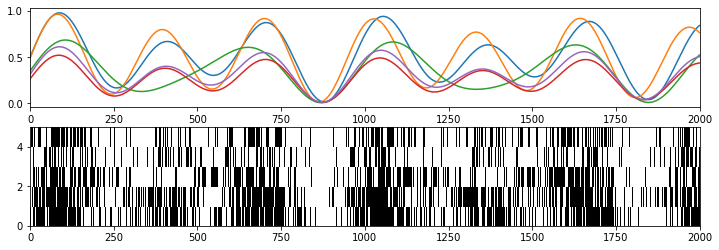

In [79]:
T = 2000
Dx = 5
Dz = 3
C = numpy.random.rand(Dx, Dz)
C /= numpy.sum(C, axis=1)[:,None]
freqs = .2 * numpy.random.rand(Dz) + .01
sines = .5 * (numpy.sin(numpy.arange(T)[:,None] * freqs[None] / 2 / numpy.pi) + 1)
rates = (.7 * numpy.random.rand(Dx) + .3)  * numpy.dot(sines, C.T)
X = numpy.array(numpy.random.rand(T, Dx) < rates, dtype=float)

pyplot.figure(figsize=(12,4))
pyplot.subplot(211)
pyplot.plot(rates)
pyplot.xlim([0,T])
pyplot.subplot(212)
pyplot.pcolor(X.T,cmap='gray_r')
pyplot.xlim([0,T])

In [ ]:
class FixedStateModel(state_models.LinearStateModel):
    
        def update_hyperparameters(self, smoothing_density: 'GaussianDensity', 
                               two_step_smoothing_density: 'GaussianDensity', **kwargs):
            """ The hyperparameters are updated here, where the the densities p(z_t|x_{1:T}) and 
            p(z_{t+1}, z_t|x_{1:T}) are provided (the latter for the cross-terms.)

            :param smoothing_density: GaussianDensity
                The smoothing density  p(z_t|x_{1:T}).
            :param two_step_smoothing_density: Gaussian Density
                The two point smoothing density  p(z_{t+1}, z_t|x_{1:T}).
            """
            #self.update_A(smoothing_density, two_step_smoothing_density)
            self.update_b(smoothing_density)
            self.update_Qz(smoothing_density, two_step_smoothing_density)
            self.update_state_density()
            
om = observation_models.BernoulliObservationModel(Dx, Dz)
sm = FixedStateModel(Dz, noise_z=.1)
ssm_em = StateSpaceEM(X, observation_model=om, state_model=sm, conv_crit=-100, max_iter=20)
ssm_em.run()

[autoreload of state_models failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../../timeseries/state_models.py", line 215
    B_mat=self.A, b_vec=se

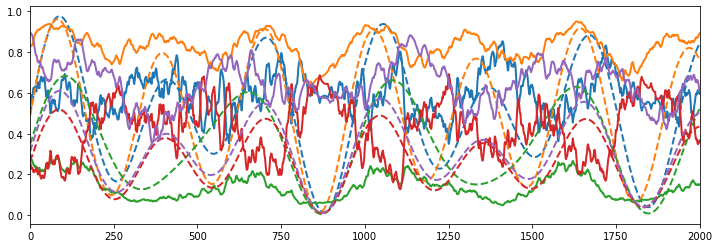

In [87]:
pyplot.figure(figsize=(12,4))
feature_vec = ssm_em.om.compute_expected_feature_vector(ssm_em.smoothing_density)
for idx in range(Dx):
    pyplot.plot(1/(1+numpy.exp(-2*numpy.dot(ssm_em.om.Theta[idx], feature_vec[:,0].T))).T, color='C%d' %idx, lw=2)
    pyplot.plot(rates[:,idx],'--', color='C%d' %idx, lw=2)
pyplot.xlim([0,T])
pyplot.show()

In [82]:
numpy.linalg.eigvals(.5*(ssm_em.sm.Qz + ssm_em.sm.Qz.T))

array([-9.10509121e-05,  1.75539913e-02,  9.02132359e-03])

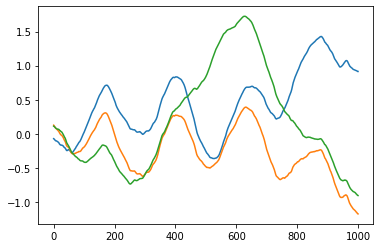

In [71]:
pyplot.plot(ssm_em.smoothing_density.mu)

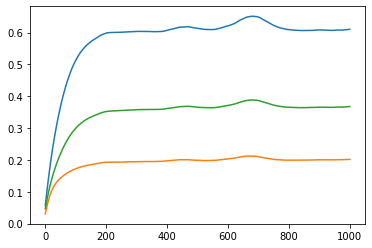

In [72]:
pyplot.plot(ssm_em.filter_density.Sigma.diagonal(axis1=1, axis2=2))

In [78]:
ssm_em.om.Theta

array([[-0.41290991, -0.05611834, -0.31844505, -0.24240539],
       [-0.27720657, -0.13852017, -0.30646884, -0.17343275],
       [-0.60375454,  0.01761385, -0.08529566, -0.08487195],
       [ 0.1308427 ,  0.06610806, -0.16431961, -0.19160082],
       [-0.12784842, -0.03375689, -0.4674215 , -0.40127108]])

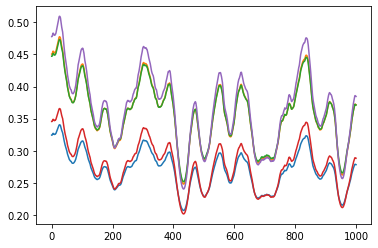

In [18]:
pyplot.plot(1/(1+numpy.exp(-numpy.dot(feature_vec[:,0], ssm_em.om.Theta.T))))

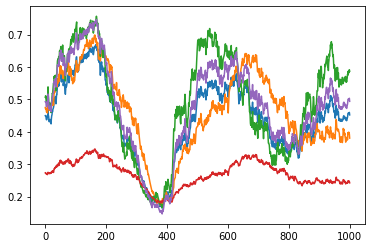

In [55]:
om.Theta

array([[-0.49300904, -0.13732854, -0.5678405 ],
       [-0.44677023,  0.36971113, -0.48683834],
       [-0.27021648, -0.55885164, -0.72562001],
       [-1.10724476,  0.15881598, -0.17286369],
       [-0.38413207, -0.15774505, -0.68957553]])

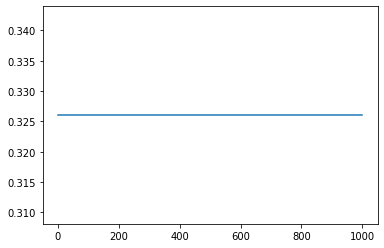

In [13]:
pyplot.plot(1/(1+numpy.exp(-numpy.dot(ssm_em.om.Theta[0,0], feature_vec[:,0,0].T))))

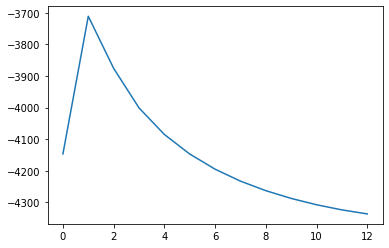

In [83]:
pyplot.plot(ssm_em.llk_list[:])